In [1]:
from dotenv import load_dotenv
from langchain_core.prompts import *
from langchain_core.output_parsers import *
from langchain_core.runnables import *
from langchain_core.messages import *
from langchain.chat_models import *

from dataclasses import *
from typing_extensions import NotRequired, TypedDict, Annotated
from typing import Any, Literal
from pydantic import BaseModel, Field 

#Basic 
from langchain.messages import *
from langchain.chat_models import  *
from langgraph.runtime import  *
from langchain.tools import  *
from langchain_core.runnables import  *

#langchain agent 
from langchain.agents import  *
from langchain.agents.structured_output import  *
from langchain.agents.middleware import  *

#Misc 
from langchain_core.documents import  *
from langchain_text_splitters import  *
from langchain_core.vectorstores import  *
from langchain_community.document_loaders import  *
from langchain_classic.tools.retriever import  *

#Langgraph 
from langgraph.graph import  *
from langgraph.prebuilt import  *
from langgraph.checkpoint.memory import  * 
from langgraph.store.memory import  *
from langgraph.cache.memory import  *
from langgraph.types import *
from langgraph.graph.message import  *

#Mistrail 
from langchain_mistralai import *

load_dotenv()

USER_AGENT environment variable not set, consider setting it to identify your requests.
USER_AGENT environment variable not set, consider setting it to identify your requests.


True

In [2]:
model = init_chat_model("open-mistral-nemo-2407", model_provider="mistralai",
    # Kwargs passed to the model:
    temperature=0,
    )

In [3]:
#Create tools 
@tool
def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: First int
        b: Second int
    """
    return a * b


@tool
def add(a: int, b: int) -> int:
    """Adds a and b.

    Args:
        a: First int
        b: Second int
    """
    return a + b


@tool
def divide(a: int, b: int) -> float:
    """Divide a and b.

    Args:
        a: First int
        b: Second int
    """
    return a / b

In [4]:
#New code 
tools = [add, multiply, divide]
tools_by_name = { tool.name: tool for tool in tools}
model_with_tools = model.bind_tools(tools)    #note bind tools, structured_output not possible

In [6]:
response = model_with_tools.invoke("What is 4+5?")

In [8]:
def tool_node(state:MessagesState): #messages - List[AnyMessage]
    result = []
    for tool_call in state["messages"][-1].tool_calls:  #list of dict
        tool = tools_by_name[tool_call['name']]  #fn 
        resp = tool.invoke(tool_call['args'])
        result.append(ToolMessage(content=resp, tool_call_id=tool_call['id']))
    return {'messages': result}

tool_node({'messages': [response]})

{'messages': [ToolMessage(content='9', tool_call_id='UOdLnokAd')]}

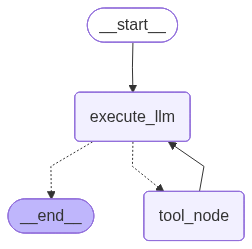

In [11]:
#Call node
def execute_llm(state:MessagesState):
    return { 'messages': [model_with_tools.invoke([
        SystemMessage("""you are a helpful calculator . Given user input , 
        do arithmatic operations based on tools supplied to you and show
        the result"""), ] + state['messages'])]}
def should_continute(state:MessagesState) -> Literal['tool_node', END]:
    messages = state['messages']
    last_message = messages[-1]  #AIMessage
    if last_message.tool_calls:
        return "tool_node"
    else:
        return END
        
gb = StateGraph(MessagesState)
gb.add_node('execute_llm', execute_llm)
gb.add_node('tool_node', tool_node)
gb.add_edge(START, 'execute_llm')
gb.add_conditional_edges('execute_llm', should_continute, ['tool_node', END])
gb.add_edge("tool_node", "execute_llm")
app = gb.compile(checkpointer=InMemorySaver())
from IPython.display import Image, display
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [12]:
config = {'configurable': {'thread_id': 1}}
messages = [HumanMessage("Add 3 and 4")]
app.invoke({'messages': messages}, config=config)

{'messages': [HumanMessage(content='Add 3 and 4', additional_kwargs={}, response_metadata={}, id='722194be-1493-4e50-9897-0e1674f77315'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '5uKr4g97A', 'function': {'name': 'add', 'arguments': '{"a": 3, "b": 4}'}, 'index': 0}]}, response_metadata={'token_usage': {'prompt_tokens': 297, 'total_tokens': 322, 'completion_tokens': 25}, 'model_name': 'open-mistral-nemo-2407', 'model': 'open-mistral-nemo-2407', 'finish_reason': 'tool_calls'}, id='lc_run--3647830a-0f7f-43c1-b058-73f0b010e19b-0', tool_calls=[{'name': 'add', 'args': {'a': 3, 'b': 4}, 'id': '5uKr4g97A', 'type': 'tool_call'}], usage_metadata={'input_tokens': 297, 'output_tokens': 25, 'total_tokens': 322}),
  ToolMessage(content='7', id='6a37d691-4196-4427-a13c-b57304cb10e1', tool_call_id='5uKr4g97A'),
  AIMessage(content='The sum of 3 and 4 is 7', additional_kwargs={}, response_metadata={'token_usage': {'prompt_tokens': 357, 'total_tokens': 369, 'completion_tokens': 1

### converting graph to agent

In [47]:
class State(AgentState):  #messages
    query: str
    answer: str

class MyContext(TypedDict):
    some_data: str|None = None 

@tool(return_direct=True)
def fallback_expert(query:str) -> str:
    "when query is ambiguous, use this to get fallback answer"
    return "I am not certain which expert should be choosen, please specify"
    
@tool 
def animal_expert(query:str, config:RunnableConfig, runtime:ToolRuntime[MyContext])->Command:
    "This gives expert knowldge of animal based on `query`"
    #print(runtime.context.get('some_data',0))
    p2 = ChatPromptTemplate.from_messages([('system', 'Your are expert on animals'),('human', '{input}')])
    c2 = p2 | model | StrOutputParser() #str
    answer = c2.invoke({'input': query})
    return answer
    #return Command(update={'answer':  answer, 'query': query, 
    #                       'messages': [ToolMessage(answer, 
    #                                                tool_call_id =runtime.tool_call_id)]})
    
@tool 
def vegetable_expert(query:str, config:RunnableConfig, runtime:ToolRuntime[MyContext])->Command:
    "This gives expert knowldge of vegetable based on `query`"
    p1 = ChatPromptTemplate.from_messages([('system', 'Your are expert on vegetables'),('human', '{input}')])
    c1 = p1 | model | StrOutputParser()
    answer = c1.invoke({'input': query})
    return answer
    #return Command(update={'answer':  answer, 'query': query, 
    #                       'messages': [ToolMessage(answer, 
    #                                                tool_call_id =runtime.tool_call_id)]})
 
system_prompt="""
You are a strict routing agent 
You must call exactly one tool
Available tools are 
for animal expertize - Use `animal_expert`
for vegetable expertize - Use `vegetable_expert` 
for ambiguous query - Use `fallback_expert`
"""
agent = create_agent(
    model = model, 
    tools= [animal_expert, vegetable_expert, fallback_expert],
    system_prompt=system_prompt, 
    state_schema = State,
    context_schema = MyContext,
    middleware= [HumanInTheLoopMiddleware(
        interrupt_on={'fallback_expert': True ,},  #approve, reject, edit
        description_prefix="Ambiguous question, select tool manually",
    )],
    #debug= True,
    checkpointer=InMemorySaver(),
)

In [48]:
config = { 'configurable': {'thread_id': 25}}
qstr = "is mushroom vegetable or animal?"
messages = [HumanMessage(qstr)]
response = agent.invoke({'messages': messages}, config=config, context={'some_data': 2})
response

{'messages': [HumanMessage(content='is mushroom vegetable or animal?', additional_kwargs={}, response_metadata={}, id='62f0b292-b8ee-43fc-b0e0-42bd2bedb8bb'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'NNG5DGFzN', 'function': {'name': 'fallback_expert', 'arguments': '{"query": "is mushroom vegetable or animal?"}'}, 'index': 0}]}, response_metadata={'token_usage': {'prompt_tokens': 264, 'total_tokens': 291, 'completion_tokens': 27}, 'model_name': 'open-mistral-nemo-2407', 'model': 'open-mistral-nemo-2407', 'finish_reason': 'tool_calls'}, id='lc_run--ff26fc79-8a71-4285-b3c8-3b1107815ee5-0', tool_calls=[{'name': 'fallback_expert', 'args': {'query': 'is mushroom vegetable or animal?'}, 'id': 'NNG5DGFzN', 'type': 'tool_call'}], usage_metadata={'input_tokens': 264, 'output_tokens': 27, 'total_tokens': 291})],
 '__interrupt__': [Interrupt(value={'action_requests': [{'name': 'fallback_expert', 'args': {'query': 'is mushroom vegetable or animal?'}, 'description': "Ambiguo

In [49]:
import pprint
pprint.pprint(response['__interrupt__'])

[Interrupt(value={'action_requests': [{'args': {'query': 'is mushroom '
                                                         'vegetable or '
                                                         'animal?'},
                                       'description': 'Ambiguous question, '
                                                      'select tool manually\n'
                                                      '\n'
                                                      'Tool: fallback_expert\n'
                                                      "Args: {'query': 'is "
                                                      'mushroom vegetable or '
                                                      "animal?'}",
                                       'name': 'fallback_expert'}],
                  'review_configs': [{'action_name': 'fallback_expert',
                                      'allowed_decisions': ['approve',
                                                         

In [50]:
agent.invoke(Command(resume={'decisions': [
        {'type':'edit','edited_action':{'name': 'vegetable_expert', 
                                        'args':{'query': qstr}, 
                                       }
        }
     ]
    }), config=config, context={'some_data': '2'})

C:\Python310\lib\site-packages\pydantic\main.py:463: UserWarning: Pydantic serializer warnings:
  PydanticSerializationUnexpectedValue(Expected `str` - serialized value may not be as expected [input_value=2, input_type=int])
  return self.__pydantic_serializer__.to_python(


{'messages': [HumanMessage(content='is mushroom vegetable or animal?', additional_kwargs={}, response_metadata={}, id='62f0b292-b8ee-43fc-b0e0-42bd2bedb8bb'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'NNG5DGFzN', 'function': {'name': 'fallback_expert', 'arguments': '{"query": "is mushroom vegetable or animal?"}'}, 'index': 0}]}, response_metadata={'token_usage': {'prompt_tokens': 264, 'total_tokens': 291, 'completion_tokens': 27}, 'model_name': 'open-mistral-nemo-2407', 'model': 'open-mistral-nemo-2407', 'finish_reason': 'tool_calls'}, id='lc_run--ff26fc79-8a71-4285-b3c8-3b1107815ee5-0', tool_calls=[{'type': 'tool_call', 'name': 'vegetable_expert', 'args': {'query': 'is mushroom vegetable or animal?'}, 'id': 'NNG5DGFzN'}], usage_metadata={'input_tokens': 264, 'output_tokens': 27, 'total_tokens': 291}),
  ToolMessage(content="Mushrooms are neither vegetables nor animals. They belong to a separate kingdom called Fungi, which also includes yeasts, molds, and lichen

### RAG

In [51]:
%pwd


'D:\\handson\\DAY7\\code\\data'

In [56]:
loader = PyMuPDFLoader("A European Approach to Artificial Intelligence - A Policy Perspective-3.pdf")
docs = loader.load()
#each page becomes one doc 
len(docs)  #docs + docs1 + ... , + for combining many docs 
dir(docs[0])
docs[0].page_content
docs[0].metadata
#Split 
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50) # Tokenization
sd = text_splitter.split_documents(docs)
len(sd)

163

In [57]:
embeddings = MistralAIEmbeddings(model='mistral-embed')

C:\Python310\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [59]:
vectorstore = InMemoryVectorStore(embeddings)
vectorstore.add_documents(documents=sd)

['3a403213-cdfc-4bbe-b2c2-f268af5fd4a4',
 'e52b57f9-fdd7-4d6c-9412-5379f2b22478',
 '860f383a-f8c0-48cf-9d5a-96d671c3986e',
 'bf90e8e0-ec34-406f-ada1-a1f6e4acf508',
 'a812ccb1-2c4c-4712-87a9-495be7a55549',
 '6a2c74dd-c519-40c7-b140-80191e094be4',
 'bf7d2986-7b2f-47f4-84c1-b4c142657e50',
 'ee4cfb9b-e7be-4c63-ba95-de0fef93f717',
 '4d632af3-db8f-4640-ac32-1555e983fdcf',
 '7f53caf0-af95-40fe-ba4c-5dec307cb34e',
 '4c3843dc-704c-4b05-9e52-bf8f8810dbec',
 'de8f882b-f481-4a6f-bf20-5f6288adbf8b',
 '1260060a-be6e-4258-bb58-fda3ba518d0c',
 '97997514-452a-48c5-a872-68967ceecf4d',
 '30efd5d1-e422-425b-9a7d-ef414a670308',
 '8f41b815-b868-4eea-adc0-55f8cea67757',
 'b05b675a-d81a-491c-87a0-a9d92e3268c0',
 '4efb3414-e527-4f09-82d6-e80abd1acdb9',
 '326f26ea-e9ad-4bfc-abd7-86d7e7b745ab',
 'ec6850ae-5c25-41a2-b244-af7634195f5d',
 'e7b8504d-231e-457c-a0cd-22a411366aa8',
 '6f6446d3-6631-460c-8d0a-c3eafddd9952',
 '277f96b2-8099-4c5b-9275-a9dbd9c04829',
 '30386f09-00b0-4872-a3e4-8dfc5041e839',
 'aed2f1ea-cc39-

In [70]:
res = vectorstore.similarity_search("URBAN MOBILITY", alpha=0.5) #Hybrid search
len(res)
res[0].metadata  # Document - metadata, page_content
#MMR 
vectorstore.similarity_search("URBAN MOBILITY", search_type='mmr', fetch_k=20, k=2) 
#MMR search , fetch 20 docs max, do MMR reranking, give me 2 docs

#create a retriever out of vectorstore
retriever  = vectorstore.as_retriever()

In [75]:
prompt = PromptTemplate.from_template("""
you are an assitant for question answering task. Use the following context to 
answer the question after Answer. 
If you are not able to find any relevant information in context,
just say "NOT FOUND"

#context
{context}

#question
{question}

#Answer:""")
chain = {'context': retriever, 'question': RunnablePassthrough()} | prompt | model | StrOutputParser()

In [73]:
question = "where has the application of AI in healthcare been confined to so far"
chain.invoke(question)

'AI applications in healthcare have been confined to administrative tasks and diagnostic support. These include:\n- Natural Language Processing to extract information from clinical notes\n- Predictive scheduling of visits\n- Machine and deep learning applied to imaging in radiology, pathology, and dermatology'

In [77]:
question = "is Tiger better than lion"
chain.invoke(question)

'NOT FOUND'

## Agentic RAG


In [79]:
@tool
def retrieve_context(query:str):
    "Retrieve information to help answer the query"
    docs = vectorstore.similarity_search(query)
    final_docs = "\n\n".join([f"""Source: {d.metadata}
    Content: {d.page_content}""" for d in docs])
    return final_docs
prompt = """You have access to a tool that retrieves context from various documents,Use that
tool to answer the user query"""
agent = create_agent(
    model = model,
    tools = [retrieve_context],
    system_prompt=prompt,
    checkpointer=InMemorySaver(),
)

In [81]:
config = {'configurable':{'thread_id': 23}}
agent.invoke({'messages':[{"role": "user", "content": question}]}, config=config)

{'messages': [HumanMessage(content='is Tiger better than lion', additional_kwargs={}, response_metadata={}, id='2c2703ea-a1bc-455d-9855-72de971a2d40'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'eWkGnQeYq', 'function': {'name': 'retrieve_context', 'arguments': '{"query": "Tiger vs Lion"}'}, 'index': 0}]}, response_metadata={'token_usage': {'prompt_tokens': 94, 'total_tokens': 118, 'completion_tokens': 24}, 'model_name': 'open-mistral-nemo-2407', 'model': 'open-mistral-nemo-2407', 'finish_reason': 'tool_calls'}, id='lc_run--5f259ae6-5477-4310-962f-736b8a92734a-0', tool_calls=[{'name': 'retrieve_context', 'args': {'query': 'Tiger vs Lion'}, 'id': 'eWkGnQeYq', 'type': 'tool_call'}], usage_metadata={'input_tokens': 94, 'output_tokens': 24, 'total_tokens': 118}),
  ToolMessage(content='Source: {\'producer\': \'Adobe PDF Library 16.0.7\', \'creator\': \'Adobe InDesign 17.3 (Macintosh)\', \'creationdate\': \'2022-08-23T10:56:11+02:00\', \'source\': \'A European Approach